In [1]:
#used for plotting
%pylab inline

#import all necessary libraries
import matplotlib
from scipy.integrate import odeint
from scipy.optimize import minimize
import numpy as np
from math import *
np.random.seed(0)

#percent of noise of the data
noise_percent = 10 #for other examples: 0, 1, 5, 25#

Populating the interactive namespace from numpy and matplotlib


##### Generate data

Text(0, 0.5, '$y$')

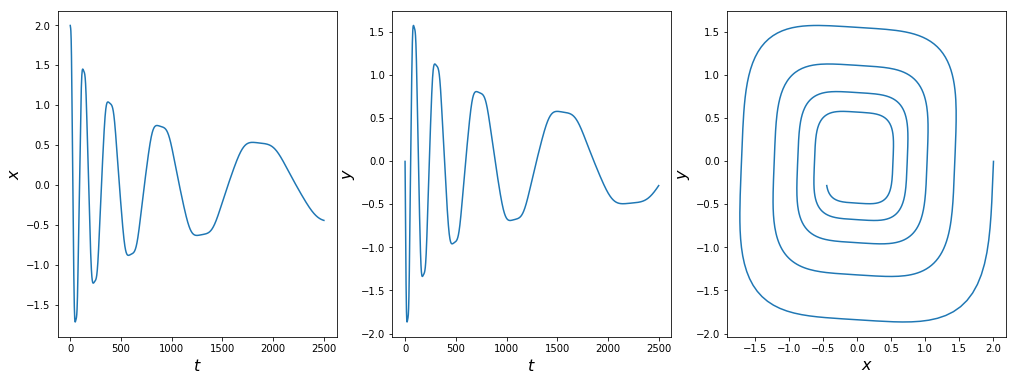

In [2]:
#ODE for damped cubic oscillator
def damped_cubic_osc(X, t, psi):
    #INPUTS:
        #X: 2-dim. array for position
        #t: 1-dim. array for time
        #psi: parameters of the dynamical system
    x,z = X
    a1,a2,a3,a4 = psi
    return [a1*x**3 + a2*z**3, a3*x**3 + a4*z**3]

#generate larger set
M = 25000
subsample_rate = 10

#take a subsample of size m = M/subsample_rate
subsample = [j for j in range(M) if j%subsample_rate == 0]

#number of measurements
m = len(subsample) 
#dimension of each measurement and state
n = 2 

#time starting at t=0 up to t=25 with M steps between
t = np.linspace(0,25,M)
#time between each sampling time
dt = ((t[1]-t[0])*subsample_rate).astype('float32')
#subsample times
t_sample = t[subsample]

#true parameters
psi_true = [-0.1, 2.0, -2.0, -0.1]

#integrate system of ODE for damped cubic oscillator, starting at [2,0] with M timesteps; take a subsample of size m
X = odeint(damped_cubic_osc, [2.0,0], t, rtol = 1e-12, atol = 1e-12, args = (psi_true,))[subsample, :].T

#set x and y
x = X[0,:]; y = X[1,:]

#plot x and y
pylab.rcParams['figure.figsize'] = (17,6)
subplot(1,3,1); plot(x)
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(1,3,2); plot(y)
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(1,3,3); plot(x,y)
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

##### Corrupt measurements with noise

In [3]:
#noise_level = % of noise * standard deviation of X
noise_level = 0.01*noise_percent*np.std(X)
#generate noise for X
measurement_noise = noise_level*np.random.randn(*X.shape)
#Y=X+noise
Y = (X + measurement_noise).astype('float64')
print(noise_level)

0.06268319041225383


##### Discretized ODE and Jacobian

In [4]:
def damped_cubic_osc_discrete(X, t, psi):
    x,z = X
    a1,a2,a3,a4 = psi
    dt = t[1]-t[0]
    return [x+dt*a1*x**3 + dt*a2*z**3, dt*a3*x**3 + dt*a4*z**3+z]

def evaluate_Jacobian(X,psi,dt):
    x, z = X
    a1, a2,a3,a4 = psi
    return np.array([[3*dt*a1*x**2+1, 3*dt*a2*z**2],[3*dt*a3*x**2, 3*dt*a4*z**2+1]])

##### Function to run the Kalman filter

In [5]:
def KalmanFilter(t, X_0, psi ,P_0, R, Y, Q):
    #INPUTS:
        #t: time
        #X_0: initial condition; E[x_0]
        #psi: parameters for unknowns
        #P_0: initial condition; Cov(x_0)
        #R: parameter for R
        #Q: parameter for Q
        #Y: measurements
        
    n,m = Y.shape
    X_p = np.zeros((n,m)) #matrix for X_plus
    X_p[:,0] = X_0 #initial condition
    X_m = np.zeros((n,m-1)) #matrix for X_minus
    
    P_p = [P_0] #list for P_plus
    P_m = [[]] #list for P_minus
    h = t[1]-t[0] #constant time step
    
    #run filter
    for i in range(1,m):
        t0 = [t[i-1], t[i]] #time-step at time i-1
        F = evaluate_Jacobian(X_p[:,i-1], psi, h) #evaluate Jacobian at time-step i-1
        
        #calculate a priori estimate with psi
        X_m[:,i-1] = damped_cubic_osc_discrete(X_p[:,i-1], t0, psi)
        # calculate a priori covariance
        P_m.append(F @ P_p[-1] @ F.T + Q)
        
        #calculate a posteriori estimate and covariance
        K = P_m[-1] @ np.linalg.inv(R + P_m[-1])
        X_p[:,i] =  X_m[:,i-1]+ K @ (Y[:,i] - X_m[:,i-1])  
        P_p.append((np.identity(n) - K)@ P_m[-1] @ (np.identity(n) - K).T + K @ R @ K.T)
    
    #OUTPUT: Filter results
    return X_m, P_m, X_p, P_p

###### Define loss function

In [6]:
def loss(psi, t, Q, R, P_0, X_0, Y):
    #INPUTS:
        #psi: parameters for unknowns
        #t: time
        #Q: parameter for Q
        #R: parameter for R
        #P_0: initial condition; Cov(x_0)
        #X_0: initial condition; E[x_0]
        #Y: measurements
        
    #obtain filter results
    X_m, P_m, X_p, P_p = KalmanFilter(t, X_0, psi, P_0, R, Y, Q)
    
    #define loss
    loss = 0
    
    n,m = Y.shape
    #calculate loss
    for k in range(1,m):
        epsilon = Y[:,k] - X_m[:,k-1]
        sigma = P_m[k] + R
        loss += np.log(np.linalg.det(sigma))+epsilon.T @ np.linalg.inv(sigma) @ epsilon
    
    #OUTPUT: evaluated log-likelihood
    return loss

##### Initial guess of parameters

In [7]:
psi = np.zeros((4))
psi[0] = np.random.normal(-1.0, 0.5)
psi[1] = np.random.normal(3.0, 1.0)
psi[2] = np.random.normal(-3.0, 1.0)
psi[3] = np.random.normal(-1.0,0.5)
print(psi)

[-0.84513809  2.26254381 -4.53691988 -1.28112741]


##### Initialize matrices

In [8]:
X_0 = X[:,0]
P_0 = 1e3*np.identity(n)
Q = 1e-5*np.identity(n)
R = 1e1*np.identity(n)

##### Plot intial filter approximation

Text(0, 0.5, '$y$')

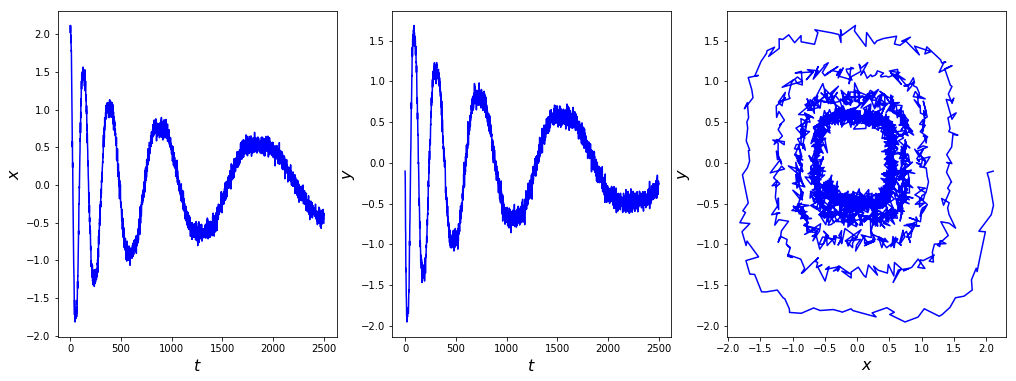

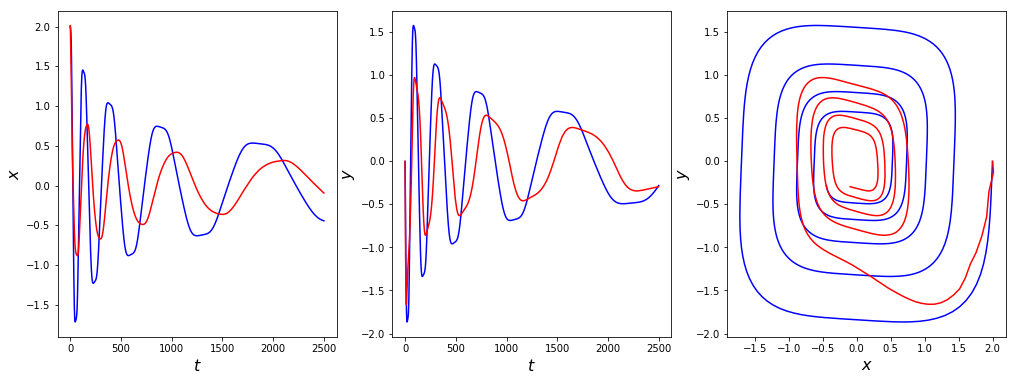

In [9]:
#initial filter approximation
X_m, P_m, X_p, P_p = KalmanFilter(t_sample, X_0, psi, P_0, R, Y, Q)

#plot
figure(figsize = (17,6))
subplot(1,3,1); plot(Y[0,:], 'b')
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(1,3,2); plot(Y[1,:], 'b')
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(1,3,3); plot(Y[0,:],Y[1,:], 'b')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

figure(figsize = (17,6))
subplot(1,3,1); plot(X[0,:], 'b'); plot(X_p[0,:], 'r')
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(1,3,2); plot(X[1,:], 'b'); plot(X_p[1,:], 'r')
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(1,3,3); plot(X[0,:],X[1,:], 'b'); plot(X_p[0,:],X_p[1,:], 'r')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

##### Minimize loss function 

In [10]:
while True: 
    #evaluate current loss
    evaluated_loss = loss(psi, t_sample, Q, R, P_0, X_0, Y)
    
    #obtain new psi by minimizing loss using L-BFGS-B optimizer
    psi_new = minimize(loss, psi, args = (t_sample, Q,R,P_0, X_0, Y), options = {'maxiter': 5})
    psi = psi_new.x
    
    print(psi)
    
    #evaluate stopping condition
    if abs(evaluated_loss - psi_new.fun) < 1e-5:
        X_m, P_m, X_p, P_p = KalmanFilter(t_sample, X_0, psi, P_0, R, Y, Q)
        break

[-0.01267418  2.83738645 -2.0835816  -0.32124737]
[-0.05938734  2.18054038 -1.9580735  -0.2011716 ]
[-0.11759097  2.03340458 -1.99954249 -0.13532898]
[-0.12517322  2.04420041 -1.98964634 -0.12818339]
[-0.12509655  2.04416574 -1.98954906 -0.12824569]


##### Plot of filter estimates

Text(0, 0.5, '$y$')

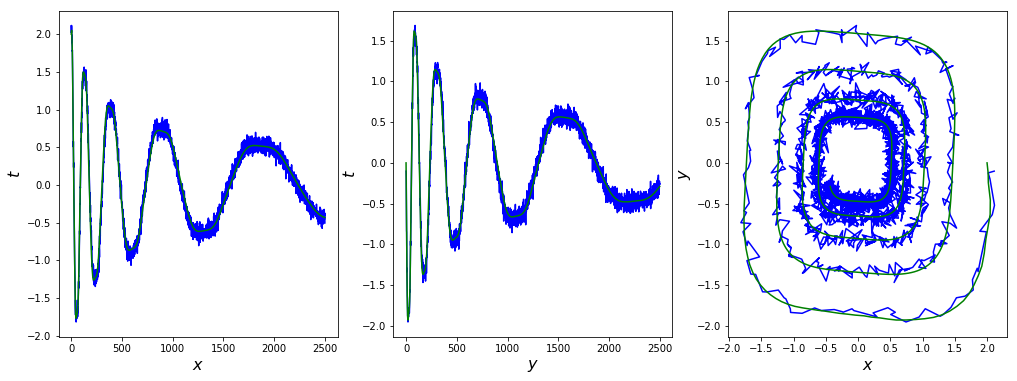

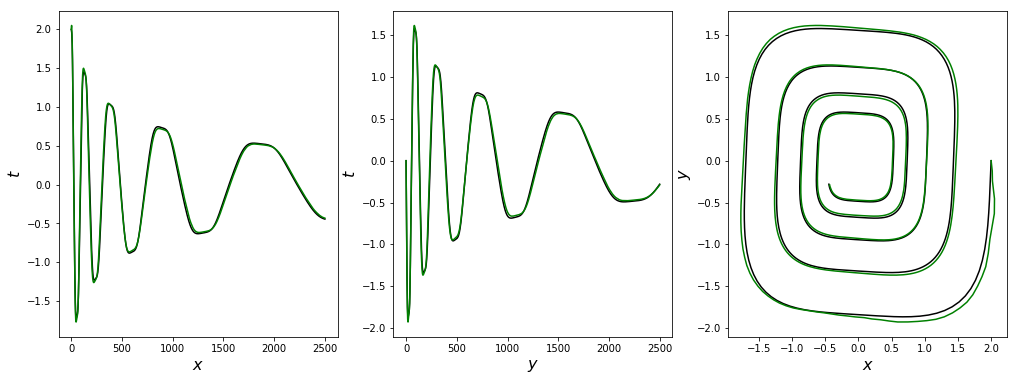

In [11]:
figure(figsize = (17,6))
subplot(1,3,1); plot(Y[0,:], 'b'); plot(X_p[0,:], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$t$', fontsize = 16)
subplot(1,3,2); plot(Y[1,:], 'b'); plot(X_p[1,:], 'g')
xlabel(r'$y$', fontsize = 16); ylabel(r'$t$', fontsize = 16)
subplot(1,3,3); plot(Y[0,:],Y[1,:], 'b'); plot(X_p[0,:],X_p[1,:], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

figure(figsize = (17,6))
subplot(1,3,1); plot(X[0,:], 'k'); plot(X_p[0,:], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$t$', fontsize = 16)
subplot(1,3,2); plot(X[1,:], 'k'); plot(X_p[1,:], 'g')
xlabel(r'$y$', fontsize = 16); ylabel(r'$t$', fontsize = 16)
subplot(1,3,3); plot(X[0,:],X[1,:], 'k'); plot(X_p[0,:],X_p[1,:], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

##### Plot of ODE run on estimated parameters

Text(0, 0.5, '$y$')

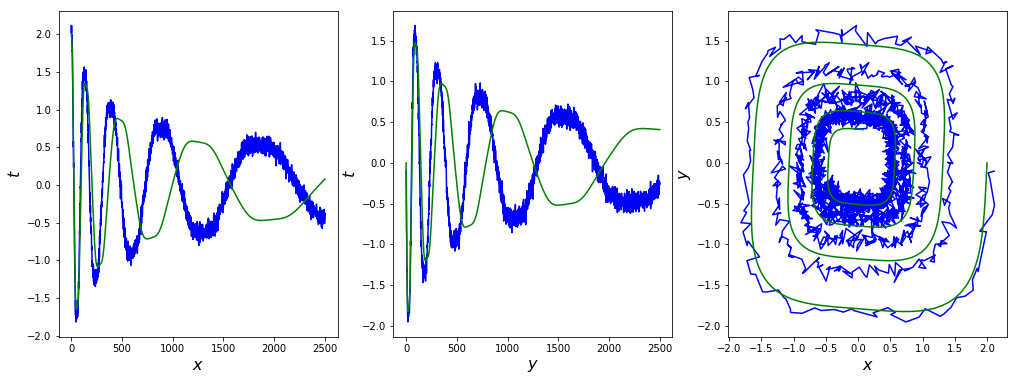

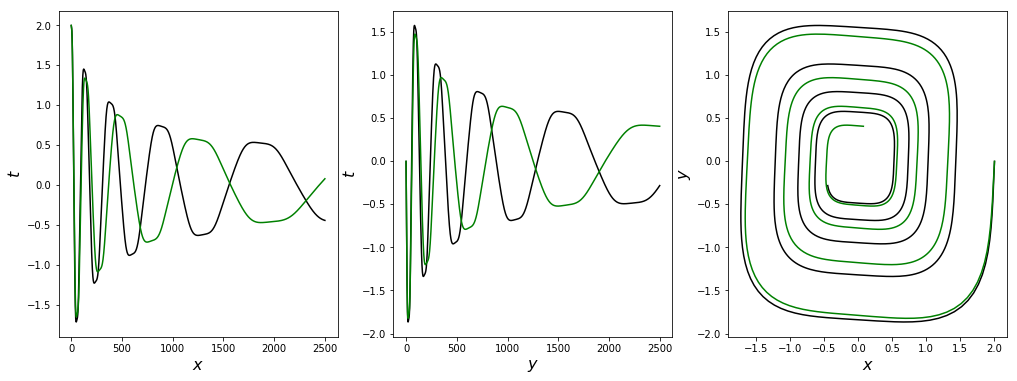

In [12]:
#ODE using estimated parameters
X_test = odeint(damped_cubic_osc, [2.0,0], t, rtol = 1e-12, atol = 1e-12, args = (psi,))[subsample, :].T

#plot
figure(figsize = (17,6))
subplot(1,3,1); plot(Y[0,:], 'b'); plot(X_test[0,:], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$t$', fontsize = 16)
subplot(1,3,2); plot(Y[1,:], 'b'); plot(X_test[1,:], 'g')
xlabel(r'$y$', fontsize = 16); ylabel(r'$t$', fontsize = 16)
subplot(1,3,3); plot(Y[0,:],Y[1,:], 'b'); plot(X_test[0,:],X_test[1,:], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

figure(figsize = (17,6))
subplot(1,3,1); plot(X[0,:], 'k'); plot(X_test[0,:], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$t$', fontsize = 16)
subplot(1,3,2); plot(X[1,:], 'k'); plot(X_test[1,:], 'g')
xlabel(r'$y$', fontsize = 16); ylabel(r'$t$', fontsize = 16)
subplot(1,3,3); plot(X[0,:],X[1,:], 'k'); plot(X_test[0,:],X_test[1,:], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

##### Plot vector field

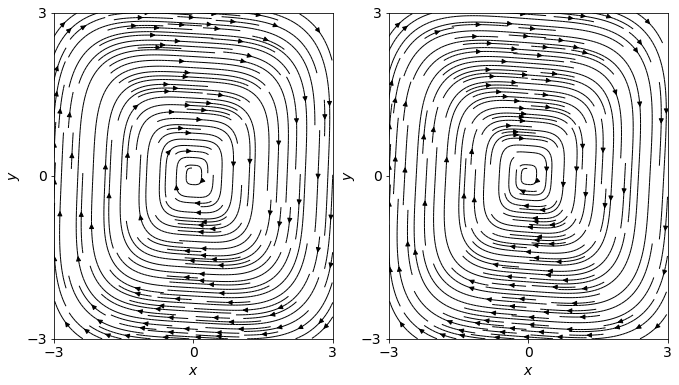

In [13]:
fig = figure(figsize = (17,6))

nx = 201
ny = 201

xmin = -3
xmax = 3
ymin = -3
ymax = 3

x = np.linspace(xmin,xmax,nx)
y = np.linspace(ymin,ymax,ny)

mesh_x,mesh_y = np.meshgrid(x, y)
true_vec_field_xy = [-0.1*mesh_x**3 + 2.0*mesh_y**3, -2.0*mesh_x**3 - 0.1*mesh_y**3]

xy = np.stack([mesh_x, mesh_y], axis = 0).astype(float32).reshape(n, nx*ny)

approx_vec_field = np.array(damped_cubic_osc(xy, t, psi)).reshape(n,nx,ny)

ax = fig.add_subplot(1, 3, 1)
ax.streamplot(mesh_x, mesh_y, true_vec_field_xy[0], true_vec_field_xy[1],\
           density=[1, 3], color = 'k', linewidth=1)
xlim([xmin,xmax])
ylim([ymin,ymax])

xlabel(r'$x$', fontsize = 14)
xticks([-3,0,3], fontsize = 14)
ylabel(r'$y$', fontsize=14)
yticks([-3,0,3], fontsize = 14)


ax = fig.add_subplot(1, 3, 2)
ax.streamplot(mesh_x, mesh_y, approx_vec_field[0,:], approx_vec_field[1,:],\
           density=[1, 3], color = 'k', linewidth=1)
xlim([xmin,xmax])
ylim([ymin,ymax])

yticks([])
xlabel('$x$', fontsize = 14)
xticks([-3,0,3], fontsize = 14)
ylabel(r'$y$', fontsize = 14)
yticks([-3,0,3], fontsize = 14)

plt.show()